In [12]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Exponential Smoothing Model for Stock Price Prediction

This notebook implements various exponential smoothing techniques (Simple, Holt's Linear Trend, and Holt-Winters) for time series forecasting with comprehensive MLflow tracking.

# MLflow Setup for Exponential Smoothing Model Tracking

In [13]:
# Import MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import os

# Set MLflow tracking URI first
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Create or get the experiment
experiment_name = "model_experiment"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"Created new experiment '{experiment_name}' with ID: {experiment_id}")
    else:
        experiment_id = experiment.experiment_id
        print(f"Using existing experiment '{experiment_name}' with ID: {experiment_id}")
    
    mlflow.set_experiment(experiment_name)
    print(f"MLflow experiment '{experiment_name}' is set up for Exponential Smoothing tracking")
except Exception as e:
    print(f"Error setting up MLflow experiment: {e}")
    # Fallback: just set the experiment (will create if not exists)
    mlflow.set_experiment(experiment_name)
    print(f"MLflow experiment '{experiment_name}' is set up (fallback method)")

Using existing experiment 'model_experiment' with ID: 1
MLflow experiment 'model_experiment' is set up for Exponential Smoothing tracking


# Import Required Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully")

All libraries imported successfully


# Load and Prepare Data

In [15]:
# Load the same data as other models for comparison
df = pd.read_csv('./vgi2.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.sort_index()

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
df.head()

Dataset shape: (854, 5)
Date range: 2018-09-25 00:00:00 to 2021-12-31 00:00:00


,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0


Close price series shape: (854,)
Close price statistics:
count    854.000000
mean      28.780211
std        6.714127
min       12.000000
25%       25.200000
50%       28.300000
75%       32.900000
max       47.500000
Name: close, dtype: float64


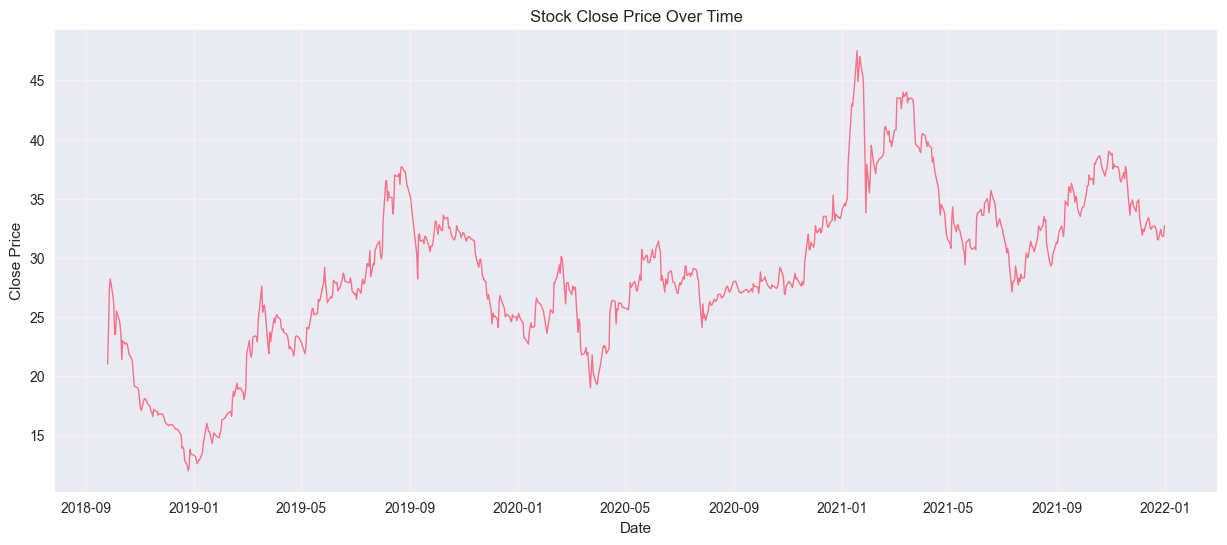

In [16]:
# Focus on close price for prediction (same as other models)
close_series = df['close'].copy()

print(f"Close price series shape: {close_series.shape}")
print(f"Close price statistics:")
print(close_series.describe())

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(close_series.index, close_series.values, linewidth=1)
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, alpha=0.3)
plt.show()

# Split Data into Train/Test Sets

Using the same split strategy as other models for fair comparison:
- Train: 80% of data 
- Test: 20% of data

This ensures consistent evaluation across all models.

Total samples: 854
Train samples: 683
Test samples: 171
Train percentage: 80.0%
Test percentage: 20.0%

Train shape: (683,)
Test shape: (171,)
Train period: 2018-09-25 00:00:00 to 2021-05-06 00:00:00
Test period: 2021-05-07 00:00:00 to 2021-12-31 00:00:00


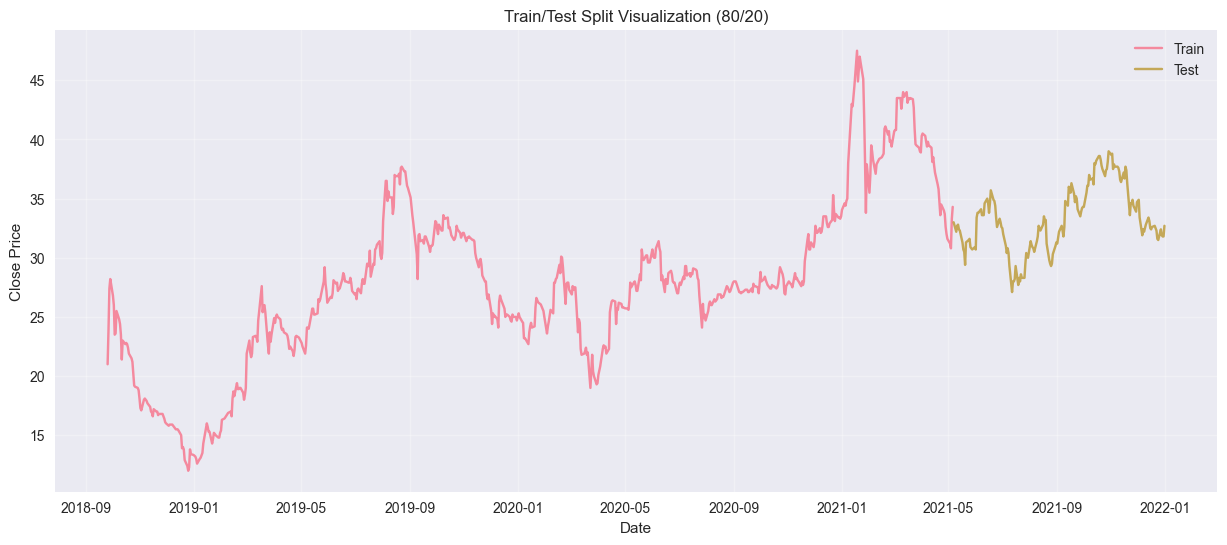

In [17]:
# Calculate split indices - 80% train / 20% test (no validation)
total_len = len(close_series)
train_len = int(0.8 * total_len)  # 80% for training
test_len = total_len - train_len  # 20% for test

print(f"Total samples: {total_len}")
print(f"Train samples: {train_len}")
print(f"Test samples: {test_len}")
print(f"Train percentage: {train_len/total_len*100:.1f}%")
print(f"Test percentage: {test_len/total_len*100:.1f}%")

# Create splits
train_series = close_series.iloc[:train_len]
test_series = close_series.iloc[train_len:]

print(f"\nTrain shape: {train_series.shape}")
print(f"Test shape: {test_series.shape}")
print(f"Train period: {train_series.index.min()} to {train_series.index.max()}")
print(f"Test period: {test_series.index.min()} to {test_series.index.max()}")

# Visualize the splits
plt.figure(figsize=(15, 6))
plt.plot(train_series.index, train_series.values, label='Train', alpha=0.8)
plt.plot(test_series.index, test_series.values, label='Test', alpha=0.8)
plt.title('Train/Test Split Visualization (80/20)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Utility Functions for Model Evaluation

In [18]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE calculation with protection against division by zero
    y_true_safe = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    
    print(f"{model_name} Metrics:")
    print(f"MSE: {mse:.5f}")
    print(f"RMSE: {rmse:.5f}")
    print(f"MAE: {mae:.5f}")
    print(f"R²: {r2:.5f}")
    print(f"MAPE: {mape:.3f}%")
    print("-" * 40)
    
    return mse, rmse, mae, r2, mape

def plot_predictions(y_true, y_pred, dates, title, mape):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(15, 6))
    plt.plot(dates, y_true, label='Actual', alpha=0.8, linewidth=2)
    plt.plot(dates, y_pred, label='Predicted', alpha=0.8, linewidth=2)
    plt.title(f'{title}\nMAPE: {mape:.3f}%')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("Utility functions defined successfully")

Utility functions defined successfully


# Simple Exponential Smoothing (SES)

Simple exponential smoothing is suitable for data with no clear trend or seasonality.

In [19]:
# Fit Simple Exponential Smoothing on training data
print("Fitting Simple Exponential Smoothing...")

ses_model = SimpleExpSmoothing(train_series)
ses_fitted = ses_model.fit()

print(f"Alpha (smoothing parameter): {ses_fitted.params['smoothing_level']:.4f}")
print(f"Initial level: {ses_fitted.params['initial_level']:.4f}")

# Make predictions
ses_train_pred = ses_fitted.fittedvalues
ses_test_pred = ses_fitted.forecast(steps=len(test_series))

print(f"Training predictions shape: {ses_train_pred.shape}")
print(f"Test predictions shape: {ses_test_pred.shape}")

Fitting Simple Exponential Smoothing...
Alpha (smoothing parameter): 1.0000
Initial level: 21.0000
Training predictions shape: (683,)
Test predictions shape: (171,)


In [20]:
# Calculate SES metrics for train and test sets
ses_train_mse, ses_train_rmse, ses_train_mae, ses_train_r2, ses_train_mape = calculate_metrics(
    train_series.values, ses_train_pred.values, "SES Training"
)

ses_test_mse, ses_test_rmse, ses_test_mae, ses_test_r2, ses_test_mape = calculate_metrics(
    test_series.values, ses_test_pred.values, "SES Test"
)

SES Training Metrics:
MSE: 0.83634
RMSE: 0.91452
MAE: 0.58931
R²: 0.98255
MAPE: 2.162%
----------------------------------------
SES Test Metrics:
MSE: 8.66094
RMSE: 2.94295
MAE: 2.45731
R²: -0.12542
MAPE: 7.621%
----------------------------------------


In [21]:
# MLflow tracking - Simple Exponential Smoothing Combined Training and Test (80/20 Split)
with mlflow.start_run(run_name="Simple_Exponential_Smoothing") as ses_run:
    print(f"Starting Simple Exponential Smoothing run: {ses_run.info.run_id}")
    
    # Log model parameters
    mlflow.log_param("model_type", "Simple_Exponential_Smoothing")
    mlflow.log_param("method", "SES")
    mlflow.log_param("train_size", len(train_series))
    mlflow.log_param("test_size", len(test_series))
    mlflow.log_param("split_ratio", "80/20")
    mlflow.log_param("smoothing_level", ses_fitted.params['smoothing_level'])
    
    # Log training metrics
    mlflow.log_metric("mse_training", ses_train_mse)
    mlflow.log_metric("rmse_training", ses_train_rmse)
    mlflow.log_metric("mae_training", ses_train_mae)
    mlflow.log_metric("r2_training", ses_train_r2)
    mlflow.log_metric("mape_training", ses_train_mape)
    
    # Log test metrics
    mlflow.log_metric("mse_test", ses_test_mse)
    mlflow.log_metric("rmse_test", ses_test_rmse)
    mlflow.log_metric("mae_test", ses_test_mae)
    mlflow.log_metric("r2_test", ses_test_r2)
    mlflow.log_metric("mape_test", ses_test_mape)
    
    # Save model with descriptive name
    mlflow.sklearn.log_model(ses_fitted, "ExponentialSmoothing_Stock_Predictor")
    
    print(f"SES Combined Metrics:")
    print(f"Training MAPE: {ses_train_mape:.3f}%")
    print(f"Test MAPE: {ses_test_mape:.3f}%")
    print(f"Test RMSE: {ses_test_rmse:.5f}")
    print("✅ Simple Exponential Smoothing model saved to MLflow")
    print(f"Combined run ID: {ses_run.info.run_id}")

Starting Simple Exponential Smoothing run: 3a8afb7a3509474b855172fc64a1b5bb


2025/10/13 16:34:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 16:34:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/13 16:34:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SES Combined Metrics:
Training MAPE: 2.162%
Test MAPE: 7.621%
Test RMSE: 2.94295
✅ Simple Exponential Smoothing model saved to MLflow
Combined run ID: 3a8afb7a3509474b855172fc64a1b5bb


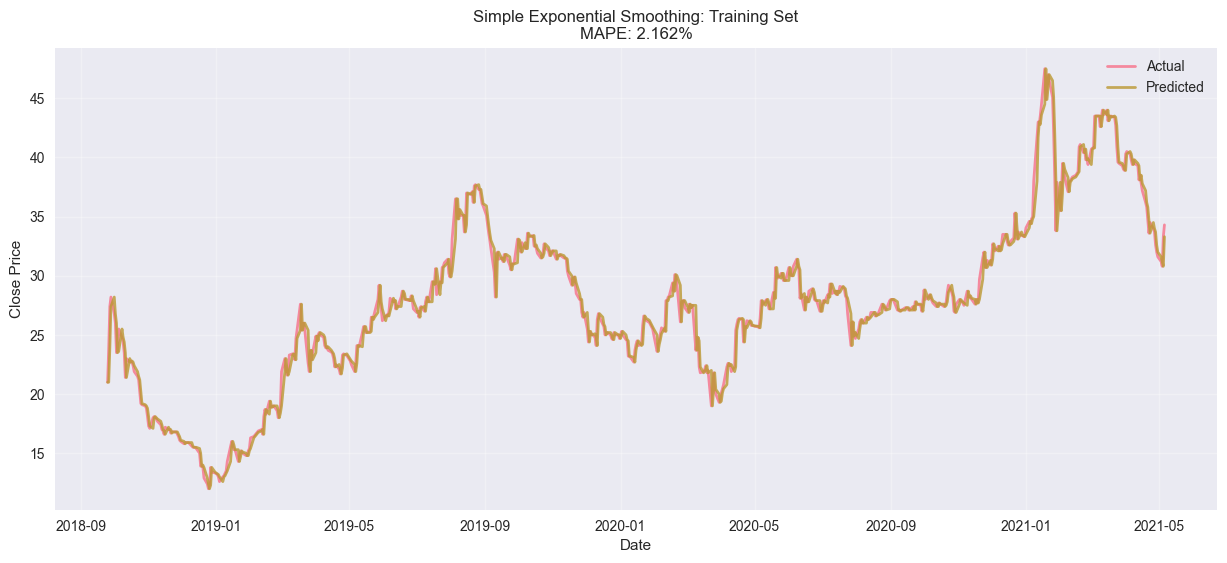

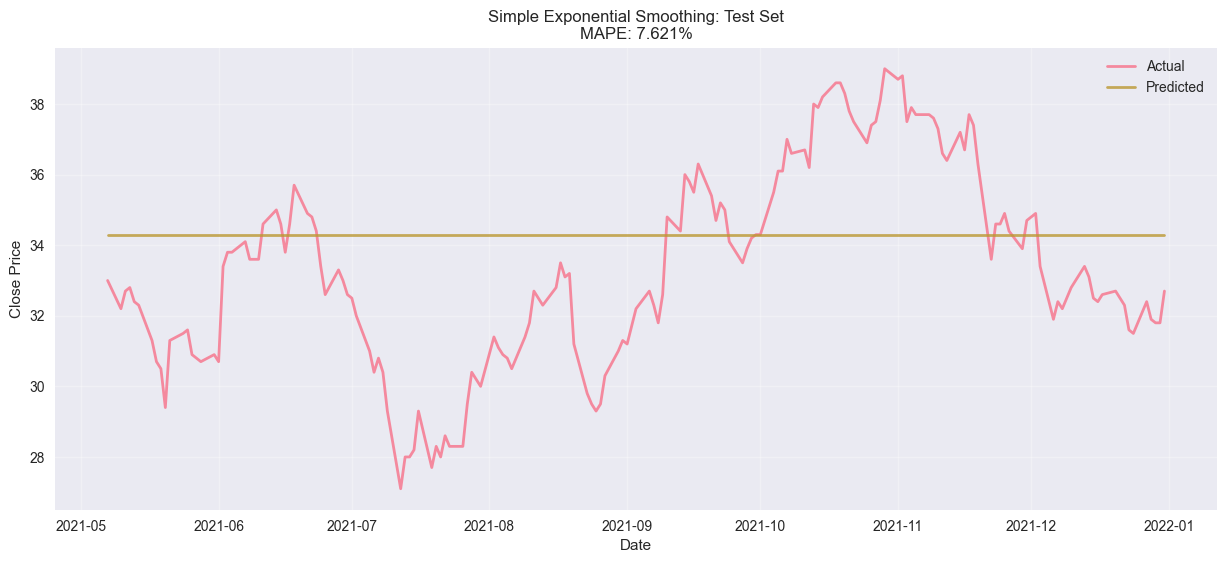

In [22]:
# Plot SES predictions
plot_predictions(train_series.values, ses_train_pred.values, train_series.index, 
                'Simple Exponential Smoothing: Training Set', ses_train_mape)

plot_predictions(test_series.values, ses_test_pred.values, test_series.index, 
                'Simple Exponential Smoothing: Test Set', ses_test_mape)

# Holt's Linear Trend Method (Double Exponential Smoothing)

Holt's method extends simple exponential smoothing to allow forecasting of data with a trend.

In [23]:
# Fit Holt's Linear Trend Method on training data
print("Fitting Holt's Linear Trend Method...")

holt_model = Holt(train_series)
holt_fitted = holt_model.fit()

print(f"Alpha (level smoothing parameter): {holt_fitted.params['smoothing_level']:.4f}")
print(f"Beta (trend smoothing parameter): {holt_fitted.params['smoothing_trend']:.4f}")
print(f"Initial level: {holt_fitted.params['initial_level']:.4f}")
print(f"Initial trend: {holt_fitted.params['initial_trend']:.4f}")

# Make predictions
holt_train_pred = holt_fitted.fittedvalues
holt_test_pred = holt_fitted.forecast(steps=len(test_series))

print(f"Training predictions shape: {holt_train_pred.shape}")
print(f"Test predictions shape: {holt_test_pred.shape}")

Fitting Holt's Linear Trend Method...
Alpha (level smoothing parameter): 1.0000
Beta (trend smoothing parameter): 0.1279
Initial level: 21.0000
Initial trend: 2.9000
Training predictions shape: (683,)
Test predictions shape: (171,)


In [24]:
# Calculate Holt's method metrics for train and test sets
holt_train_mse, holt_train_rmse, holt_train_mae, holt_train_r2, holt_train_mape = calculate_metrics(
    train_series.values, holt_train_pred.values, "Holt Training"
)

holt_test_mse, holt_test_rmse, holt_test_mae, holt_test_r2, holt_test_mape = calculate_metrics(
    test_series.values, holt_test_pred.values, "Holt Test"
)

Holt Training Metrics:
MSE: 0.93037
RMSE: 0.96455
MAE: 0.62509
R²: 0.98059
MAPE: 2.298%
----------------------------------------
Holt Test Metrics:
MSE: 47.33150
RMSE: 6.87979
MAE: 6.16290
R²: -5.15037
MAPE: 19.001%
----------------------------------------


In [25]:
# MLflow tracking - Holt Linear Trend Combined Training and Test (80/20 Split)
with mlflow.start_run(run_name="Holt_Linear_Trend") as holt_run:
    print(f"Starting Holt Linear Trend run: {holt_run.info.run_id}")
    
    # Log model parameters
    mlflow.log_param("model_type", "Holt_Linear_Trend")
    mlflow.log_param("method", "Holt")
    mlflow.log_param("train_size", len(train_series))
    mlflow.log_param("test_size", len(test_series))
    mlflow.log_param("split_ratio", "80/20")
    mlflow.log_param("smoothing_level", holt_fitted.params['smoothing_level'])
    mlflow.log_param("smoothing_trend", holt_fitted.params['smoothing_trend'])
    
    # Log training metrics
    mlflow.log_metric("mse_training", holt_train_mse)
    mlflow.log_metric("rmse_training", holt_train_rmse)
    mlflow.log_metric("mae_training", holt_train_mae)
    mlflow.log_metric("r2_training", holt_train_r2)
    mlflow.log_metric("mape_training", holt_train_mape)
    
    # Log test metrics
    mlflow.log_metric("mse_test", holt_test_mse)
    mlflow.log_metric("rmse_test", holt_test_rmse)
    mlflow.log_metric("mae_test", holt_test_mae)
    mlflow.log_metric("r2_test", holt_test_r2)
    mlflow.log_metric("mape_test", holt_test_mape)
    
    # Save model with descriptive name
    mlflow.sklearn.log_model(holt_fitted, "ExponentialSmoothing_Stock_Predictor")
    
    print(f"Holt Combined Metrics:")
    print(f"Training MAPE: {holt_train_mape:.3f}%")
    print(f"Test MAPE: {holt_test_mape:.3f}%")
    print(f"Test RMSE: {holt_test_rmse:.5f}")
    print("✅ Holt Linear Trend model saved to MLflow")
    print(f"Combined run ID: {holt_run.info.run_id}")

Starting Holt Linear Trend run: e6bf2fd9859744dbb9b0a82d4add6ab5



2025/10/13 16:34:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 16:34:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/13 16:34:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Holt Combined Metrics:
Training MAPE: 2.298%
Test MAPE: 19.001%
Test RMSE: 6.87979
✅ Holt Linear Trend model saved to MLflow
Combined run ID: e6bf2fd9859744dbb9b0a82d4add6ab5


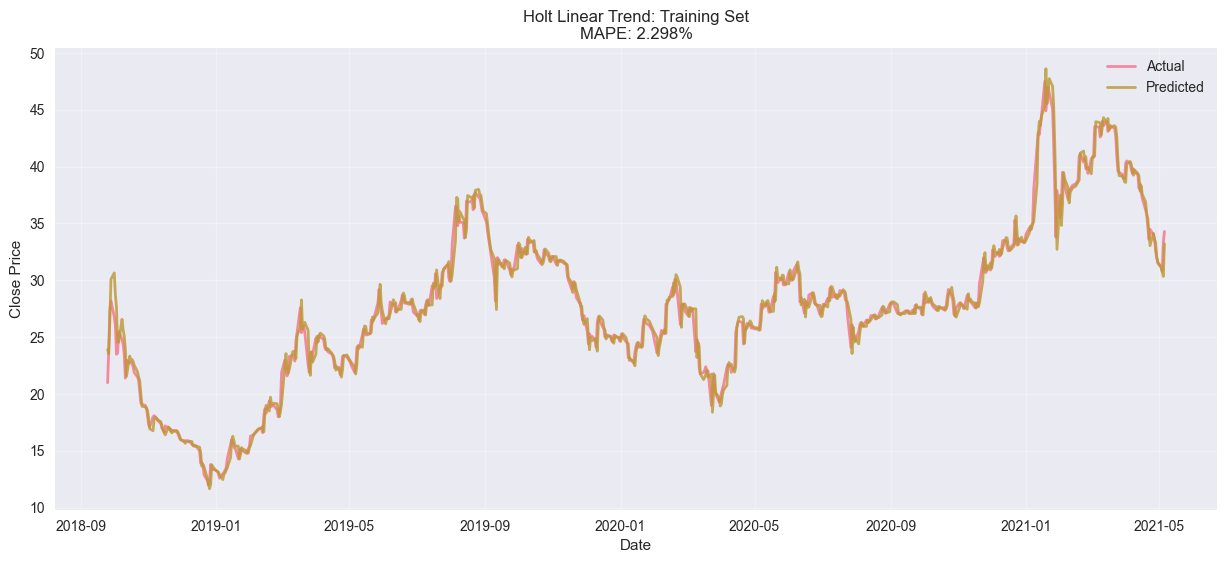

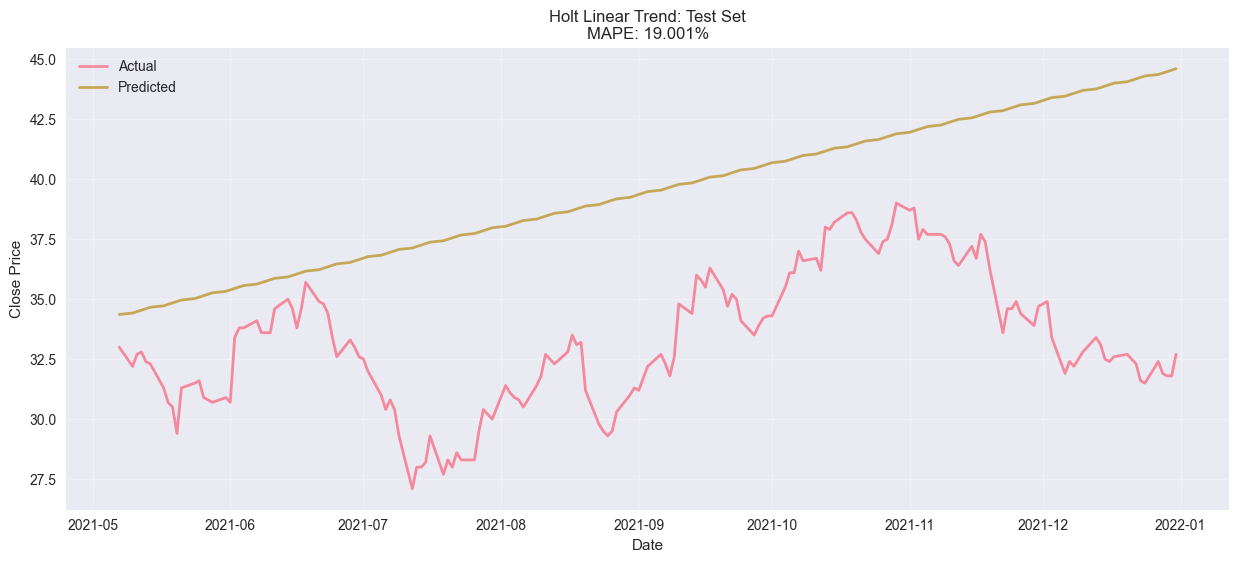

In [26]:
# Plot Holt's method predictions
plot_predictions(train_series.values, holt_train_pred.values, train_series.index, 
                'Holt Linear Trend: Training Set', holt_train_mape)

plot_predictions(test_series.values, holt_test_pred.values, test_series.index, 
                'Holt Linear Trend: Test Set', holt_test_mape)

# Holt-Winters Method (Triple Exponential Smoothing)

Holt-Winters method extends Holt's method to capture seasonality.

In [27]:
# Fit Holt-Winters Method on training data
print("Fitting Holt-Winters Method...")

# Try to fit Holt-Winters with seasonal component
try:
    hw_model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12)
    hw_fitted = hw_model.fit()
    seasonal_params = f"seasonal_periods=12"
except:
    # Fallback to trend-only if seasonal fails
    print("Seasonal component failed, using trend-only Holt-Winters")
    hw_model = ExponentialSmoothing(train_series, trend='add', seasonal=None)
    hw_fitted = hw_model.fit()
    seasonal_params = "seasonal=None"

print(f"Model parameters: trend='add', {seasonal_params}")
print(f"Alpha (level): {hw_fitted.params.get('smoothing_level', 'N/A'):.4f}")
print(f"Beta (trend): {hw_fitted.params.get('smoothing_trend', 'N/A'):.4f}")
if 'smoothing_seasonal' in hw_fitted.params:
    print(f"Gamma (seasonal): {hw_fitted.params['smoothing_seasonal']:.4f}")

# Make predictions
hw_train_pred = hw_fitted.fittedvalues
hw_test_pred = hw_fitted.forecast(steps=len(test_series))

print(f"Training predictions shape: {hw_train_pred.shape}")
print(f"Test predictions shape: {hw_test_pred.shape}")

Fitting Holt-Winters Method...
Model parameters: trend='add', seasonal_periods=12
Alpha (level): 1.0000
Beta (trend): 0.0000
Gamma (seasonal): 0.0000
Training predictions shape: (683,)
Test predictions shape: (171,)
Model parameters: trend='add', seasonal_periods=12
Alpha (level): 1.0000
Beta (trend): 0.0000
Gamma (seasonal): 0.0000
Training predictions shape: (683,)
Test predictions shape: (171,)


In [28]:
# Calculate Holt-Winters metrics for train and test sets
hw_train_mse, hw_train_rmse, hw_train_mae, hw_train_r2, hw_train_mape = calculate_metrics(
    train_series.values, hw_train_pred.values, "Holt-Winters Training"
)

hw_test_mse, hw_test_rmse, hw_test_mae, hw_test_r2, hw_test_mape = calculate_metrics(
    test_series.values, hw_test_pred.values, "Holt-Winters Test"
)

Holt-Winters Training Metrics:
MSE: 0.82829
RMSE: 0.91010
MAE: 0.59400
R²: 0.98272
MAPE: 2.179%
----------------------------------------
Holt-Winters Test Metrics:
MSE: 13.88914
RMSE: 3.72681
MAE: 3.06375
R²: -0.80479
MAPE: 9.732%
----------------------------------------


In [29]:
# MLflow tracking - Holt-Winters Combined Training and Test (80/20 Split)
with mlflow.start_run(run_name="Holt_Winters") as hw_run:
    print(f"Starting Holt-Winters run: {hw_run.info.run_id}")
    
    # Log model parameters
    mlflow.log_param("model_type", "Holt_Winters")
    mlflow.log_param("method", "Holt-Winters")
    mlflow.log_param("train_size", len(train_series))
    mlflow.log_param("test_size", len(test_series))
    mlflow.log_param("split_ratio", "80/20")
    mlflow.log_param("trend", "add")
    mlflow.log_param("seasonal", "add" if 'smoothing_seasonal' in hw_fitted.params else "None")
    if 'smoothing_seasonal' in hw_fitted.params:
        mlflow.log_param("seasonal_periods", 12)
    
    # Log training metrics
    mlflow.log_metric("mse_training", hw_train_mse)
    mlflow.log_metric("rmse_training", hw_train_rmse)
    mlflow.log_metric("mae_training", hw_train_mae)
    mlflow.log_metric("r2_training", hw_train_r2)
    mlflow.log_metric("mape_training", hw_train_mape)
    
    # Log test metrics
    mlflow.log_metric("mse_test", hw_test_mse)
    mlflow.log_metric("rmse_test", hw_test_rmse)
    mlflow.log_metric("mae_test", hw_test_mae)
    mlflow.log_metric("r2_test", hw_test_r2)
    mlflow.log_metric("mape_test", hw_test_mape)
    
    # Save model with descriptive name
    mlflow.sklearn.log_model(hw_fitted, "ExponentialSmoothing_Stock_Predictor")
    
    print(f"Holt-Winters Combined Metrics:")
    print(f"Training MAPE: {hw_train_mape:.3f}%")
    print(f"Test MAPE: {hw_test_mape:.3f}%")
    print(f"Test RMSE: {hw_test_rmse:.5f}")
    print("✅ Holt-Winters model saved to MLflow")
    print(f"Combined run ID: {hw_run.info.run_id}")

Starting Holt-Winters run: a0fa8a1fb8f34b8d98929f007cde1749


2025/10/13 16:34:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 16:34:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/13 16:34:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Holt-Winters Combined Metrics:
Training MAPE: 2.179%
Test MAPE: 9.732%
Test RMSE: 3.72681
✅ Holt-Winters model saved to MLflow
Combined run ID: a0fa8a1fb8f34b8d98929f007cde1749


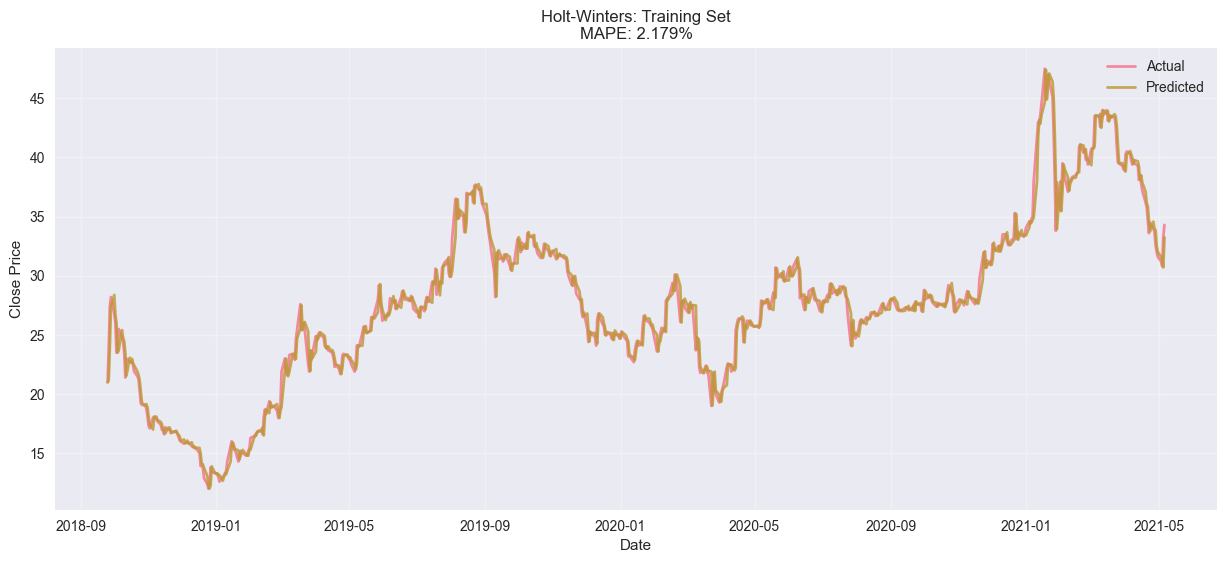

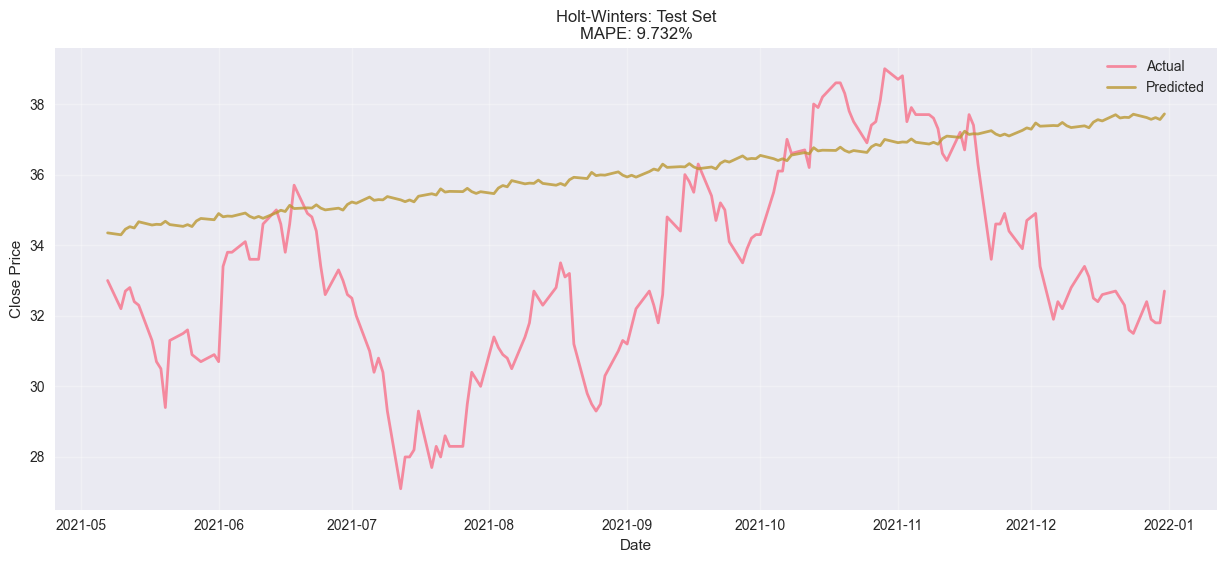

In [30]:
# Plot Holt-Winters predictions
plot_predictions(train_series.values, hw_train_pred.values, train_series.index, 
                'Holt-Winters: Training Set', hw_train_mape)

plot_predictions(test_series.values, hw_test_pred.values, test_series.index, 
                'Holt-Winters: Test Set', hw_test_mape)

# Model Comparison Summary

📊 EXPONENTIAL SMOOTHING MODELS COMPARISON
                       Model  Training_MAPE  Test_MAPE  Training_RMSE  Test_RMSE
Simple Exponential Smoothing          2.162      7.621          0.915      2.943
           Holt Linear Trend          2.298     19.001          0.965      6.880
                Holt-Winters          2.179      9.732          0.910      3.727

🏆 BEST EXPONENTIAL SMOOTHING MODEL: Simple Exponential Smoothing
Test MAPE: 7.621%


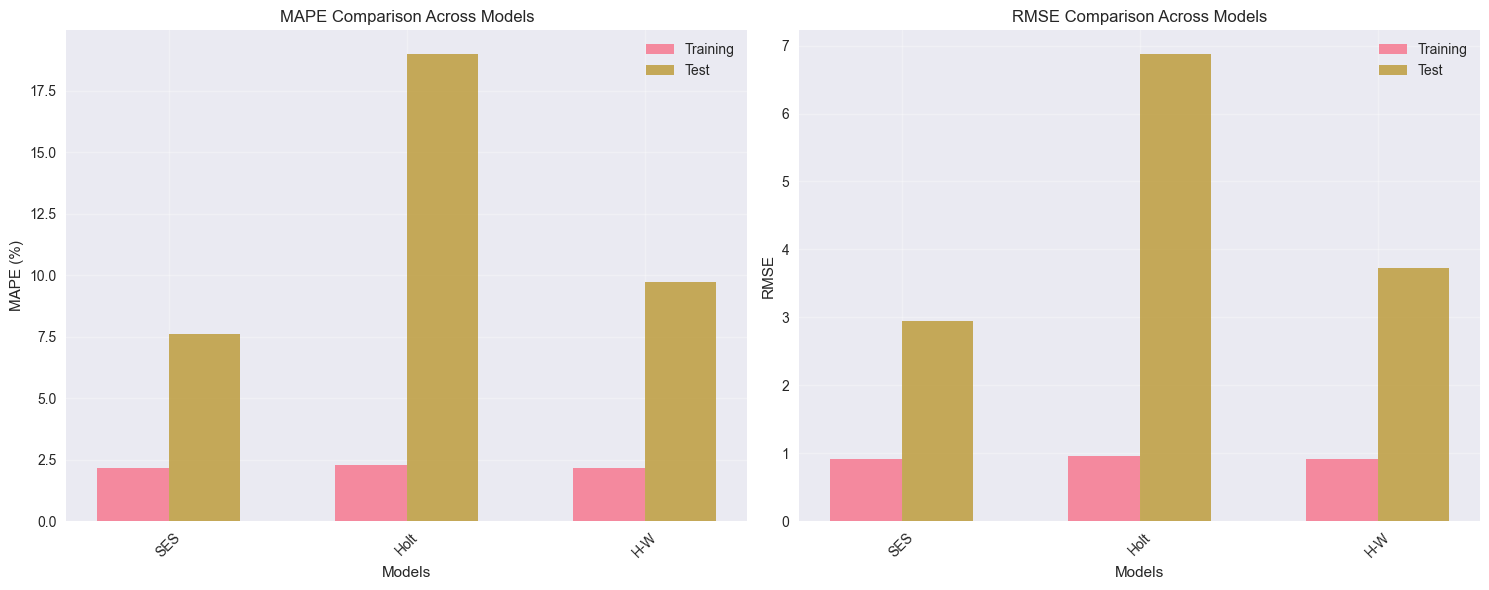


📁 Saved test predictions to: exponential_smoothing_test_predictions.csv


In [31]:
# Create comparison summary
comparison_data = {
    'Model': ['Simple Exponential Smoothing', 'Holt Linear Trend', 'Holt-Winters'],
    'Training_MAPE': [ses_train_mape, holt_train_mape, hw_train_mape],
    'Test_MAPE': [ses_test_mape, holt_test_mape, hw_test_mape],
    'Training_RMSE': [ses_train_rmse, holt_train_rmse, hw_train_rmse],
    'Test_RMSE': [ses_test_rmse, holt_test_rmse, hw_test_rmse]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(3)

print("📊 EXPONENTIAL SMOOTHING MODELS COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Find best model by test MAPE
best_test_idx = comparison_df['Test_MAPE'].idxmin()
best_model = comparison_df.iloc[best_test_idx]['Model']
best_test_mape = comparison_df.iloc[best_test_idx]['Test_MAPE']

print(f"\n🏆 BEST EXPONENTIAL SMOOTHING MODEL: {best_model}")
print(f"Test MAPE: {best_test_mape:.3f}%")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# MAPE comparison
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos - 0.15, comparison_df['Training_MAPE'], 0.3, label='Training', alpha=0.8)
axes[0].bar(x_pos + 0.15, comparison_df['Test_MAPE'], 0.3, label='Test', alpha=0.8)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('MAPE (%)')
axes[0].set_title('MAPE Comparison Across Models')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['SES', 'Holt', 'H-W'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE comparison
axes[1].bar(x_pos - 0.15, comparison_df['Training_RMSE'], 0.3, label='Training', alpha=0.8)
axes[1].bar(x_pos + 0.15, comparison_df['Test_RMSE'], 0.3, label='Test', alpha=0.8)
axes[1].set_xlabel('Models')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison Across Models')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['SES', 'Holt', 'H-W'], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save combined test predictions
test_predictions_df = pd.DataFrame({
    'date': test_series.index,
    'actual': test_series.values,
    'SES_predicted': ses_test_pred.values,
    'Holt_predicted': holt_test_pred.values,
    'HoltWinters_predicted': hw_test_pred.values
})

test_predictions_df.to_csv("exponential_smoothing_test_predictions.csv", index=False)
print("\n📁 Saved test predictions to: exponential_smoothing_test_predictions.csv")

# Compare with Other Models from MLflow

In [32]:
# Compare with other models from MLflow
try:
    # Get current experiment
    experiment = mlflow.get_experiment_by_name("model_experiment")
    
    # Search all runs from this experiment
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"]
    )
    
    # Filter and display results
    if len(runs) > 0:
        print("🎯 MODEL PERFORMANCE COMPARISON WITH ALL MODELS")
        print("=" * 80)
        
        # Select relevant columns for comparison
        comparison_cols = ['tags.mlflow.runName', 'params.model_type']
        metric_cols = [col for col in runs.columns if 'metrics.' in col]
        
        display_cols = comparison_cols + metric_cols
        available_cols = [col for col in display_cols if col in runs.columns]
        
        comparison_df_full = runs[available_cols].copy()
        
        # Clean up column names for display
        for col in comparison_df_full.columns:
            if col.startswith('metrics.'):
                new_col = col.replace('metrics.', '')
                comparison_df_full = comparison_df_full.rename(columns={col: new_col})
            elif col.startswith('params.'):
                new_col = col.replace('params.', '')
                comparison_df_full = comparison_df_full.rename(columns={col: new_col})
            elif col.startswith('tags.'):
                new_col = col.replace('tags.', '').replace('mlflow.', '')
                comparison_df_full = comparison_df_full.rename(columns={col: new_col})
        
        # Display comparison (first 20 rows to avoid overflow)
        print(comparison_df_full.head(20).to_string(index=False))
        
        # Find best models by test MAPE
        test_mape_cols = [col for col in comparison_df_full.columns if 'mape_test' in col.lower()]
        if test_mape_cols:
            test_runs = comparison_df_full.dropna(subset=test_mape_cols)
            if len(test_runs) > 0:
                test_runs_sorted = test_runs.sort_values(test_mape_cols[0])
                print(f"\n📊 RANKING BY TEST MAPE (Lower is Better):")
                print("=" * 50)
                for i, (idx, row) in enumerate(test_runs_sorted.head(10).iterrows()):
                    run_name = row.get('runName', 'Unknown')
                    model_type = row.get('model_type', 'Unknown')
                    mape = row[test_mape_cols[0]]
                    print(f"{i+1}. {run_name} ({model_type}): {mape:.3f}% MAPE")
                
                best_test_run = test_runs_sorted.iloc[0]
                print(f"\n🏆 OVERALL BEST MODEL: {best_test_run.get('runName', 'Unknown')} with {best_test_run[test_mape_cols[0]]:.3f}% MAPE")
        
        print(f"\n🔗 View detailed comparison at: http://127.0.0.1:5001")
        
    else:
        print("No previous runs found for comparison")
        
except Exception as e:
    print(f"Error retrieving MLflow runs: {e}")
    print("Make sure MLflow server is running and experiment exists")

🎯 MODEL PERFORMANCE COMPARISON WITH ALL MODELS
                     runName                   model_type  mae_test   r2_test  r2_training  mape_training  mse_test  mae_training  mape_test  rmse_test  rmse_training  mse_training  final_train_loss    val_r2  test_mse  val_mae    test_r2  train_r2  val_rmse  train_rmse  test_mae  train_mae  test_mape  train_mse  test_rmse  final_val_loss   val_mse  train_mape  val_mape  test_residual_r2  val_residual_mae  val_residual_rmse  test_residual_mape  test_residual_mse  val_residual_mse  test_residual_rmse  val_residual_r2  test_residual_mae  val_residual_mape
                Holt_Winters                 Holt_Winters  3.063748 -0.804788     0.982718       2.178932 13.889137      0.593999   9.731678   3.726813       0.910104      0.828289               NaN       NaN       NaN      NaN        NaN       NaN       NaN         NaN       NaN        NaN        NaN        NaN        NaN             NaN       NaN         NaN       NaN               NaN   

# Summary and Insights

In [33]:
print("✅ EXPONENTIAL SMOOTHING MODELS ANALYSIS COMPLETED")
print("=" * 70)
print("\n📊 EXPONENTIAL SMOOTHING RESULTS SUMMARY:")
print(f"📈 Simple Exponential Smoothing - Test MAPE: {ses_test_mape:.3f}%")
print(f"📈 Holt Linear Trend - Test MAPE: {holt_test_mape:.3f}%")
print(f"📈 Holt-Winters - Test MAPE: {hw_test_mape:.3f}%")

print(f"\n🏆 Best Exponential Smoothing Model: {best_model}")
print(f"🎯 Best Test MAPE: {best_test_mape:.3f}%")

print("\n🎯 MLflow Tracking:")
print("- All three exponential smoothing methods tracked")
print("- Training and test metrics logged in single runs")
print("- Model artifacts saved for each method")
print("- Consistent metric naming for comparison")

print("\n💡 Key Insights:")
print("- Exponential smoothing methods provide baseline forecasts")
print("- All metrics use consistent naming for easy comparison with other models")
print("- Results can be compared with ARIMA, CNN-LSTM, and other models in MLflow")
print("- Methods capture different aspects: SES (level), Holt (trend), H-W (seasonality)")

print(f"\n🔗 View all results in MLflow UI: http://127.0.0.1:5001")

✅ EXPONENTIAL SMOOTHING MODELS ANALYSIS COMPLETED

📊 EXPONENTIAL SMOOTHING RESULTS SUMMARY:
📈 Simple Exponential Smoothing - Test MAPE: 7.621%
📈 Holt Linear Trend - Test MAPE: 19.001%
📈 Holt-Winters - Test MAPE: 9.732%

🏆 Best Exponential Smoothing Model: Simple Exponential Smoothing
🎯 Best Test MAPE: 7.621%

🎯 MLflow Tracking:
- All three exponential smoothing methods tracked
- Training and test metrics logged in single runs
- Model artifacts saved for each method
- Consistent metric naming for comparison

💡 Key Insights:
- Exponential smoothing methods provide baseline forecasts
- All metrics use consistent naming for easy comparison with other models
- Results can be compared with ARIMA, CNN-LSTM, and other models in MLflow
- Methods capture different aspects: SES (level), Holt (trend), H-W (seasonality)

🔗 View all results in MLflow UI: http://127.0.0.1:5001


# Overall Model Performance Analysis Across All Models

🎯 COMPREHENSIVE MODEL PERFORMANCE ANALYSIS

📊 ALL MODELS RANKED BY TEST MAPE (Lower is Better):
----------------------------------------------------------------------------------------------------
                        runName                    model_type  mape_test  rmse_test  mae_test  r2_test
0  Simple_Exponential_Smoothing  Simple_Exponential_Smoothing      7.621    2.94295   2.45731 -0.12542
1                  Holt_Winters                  Holt_Winters      9.732    3.72681   3.06375 -0.80479
2                BiGRU_Training             Bidirectional GRU     12.565    4.29253   4.20699 -1.31733
3             Holt_Linear_Trend             Holt_Linear_Trend     19.001    6.87979   6.16290 -5.15037


🏆 BEST OVERALL MODEL
Model Name: Simple_Exponential_Smoothing
Model Type: Simple_Exponential_Smoothing

📈 Test Performance:
   MAPE:  7.621%  (Lower is better)
   RMSE:  2.94295  (Lower is better)
   MAE:   2.45731  (Lower is better)
   R²:    -0.12542  (Higher is better)

📊 Training P

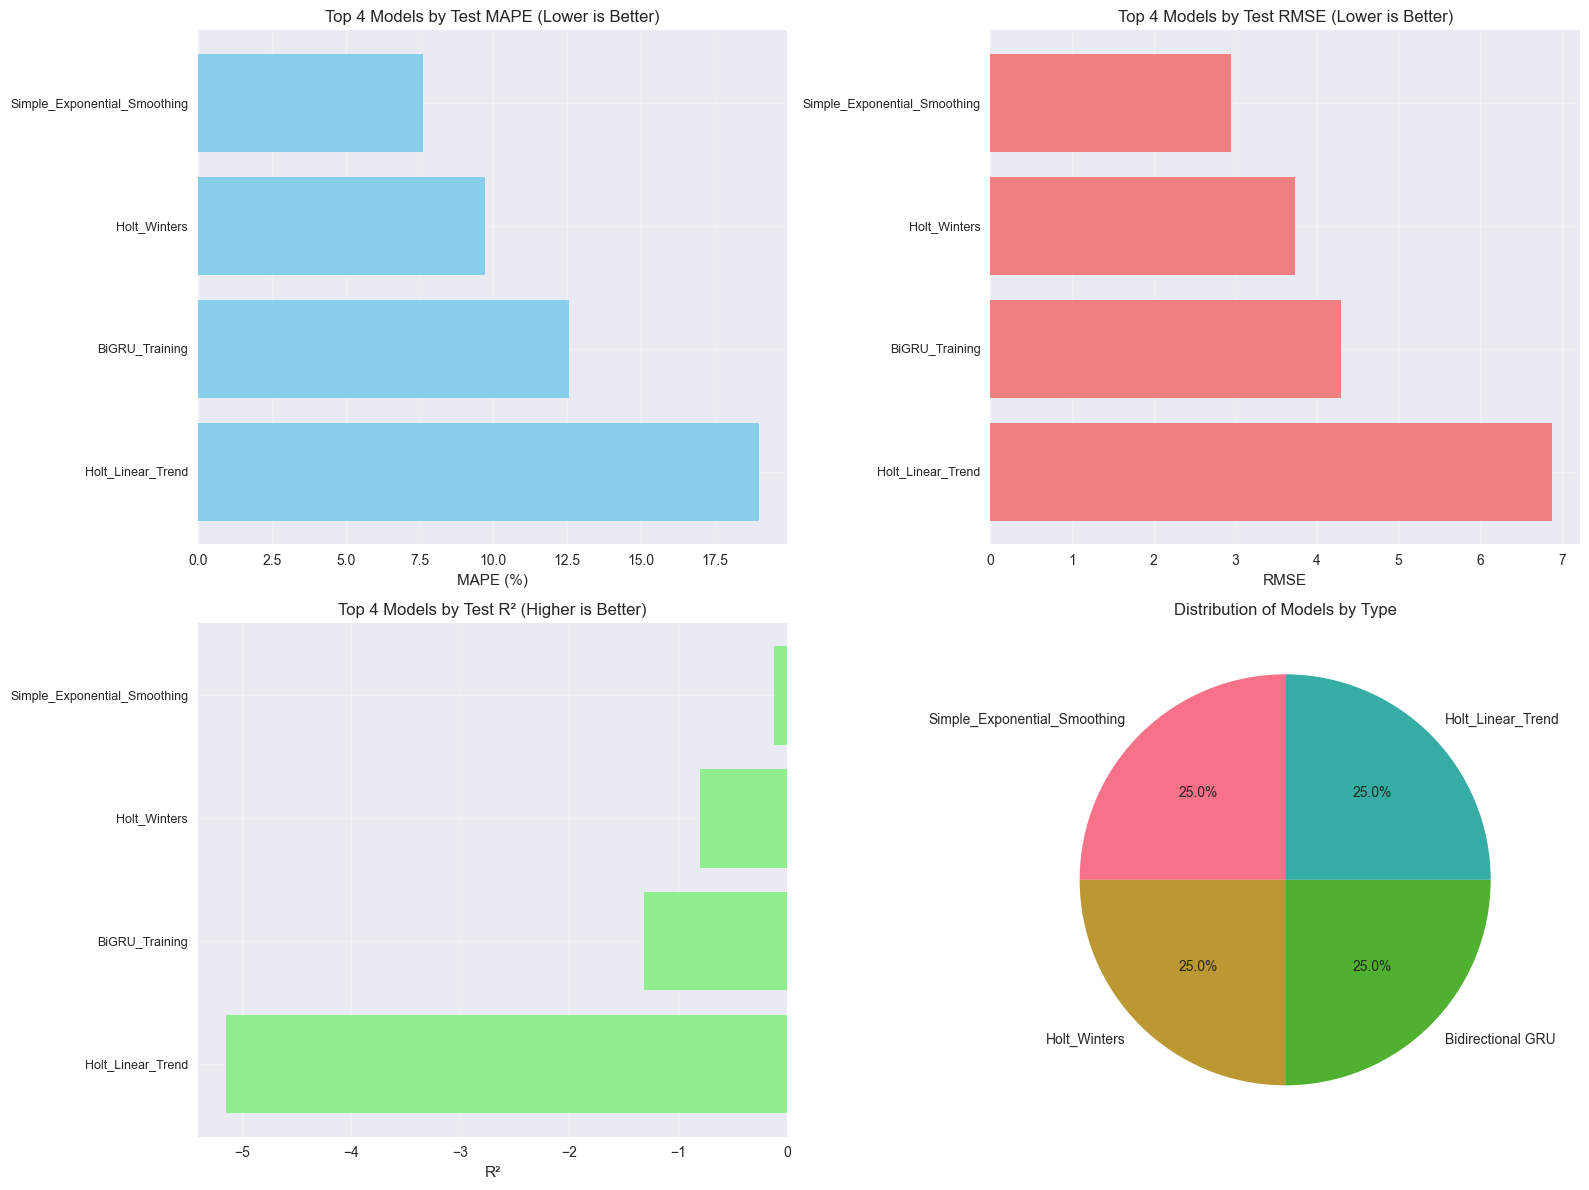


🔗 View detailed comparison in MLflow UI: http://127.0.0.1:5001


In [34]:
# Comprehensive analysis of all models from MLflow
try:
    # Get current experiment
    experiment = mlflow.get_experiment_by_name("model_experiment")
    
    if experiment:
        # Search all runs from this experiment
        runs = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["start_time DESC"]
        )
        
        if len(runs) > 0:
            print("="*100)
            print("🎯 COMPREHENSIVE MODEL PERFORMANCE ANALYSIS")
            print("="*100)
            
            # Select relevant columns
            metrics_cols = ['tags.mlflow.runName', 'params.model_type', 'params.architecture',
                            'metrics.mape_test', 'metrics.rmse_test', 'metrics.mae_test', 'metrics.r2_test',
                            'metrics.mape_training', 'metrics.rmse_training', 'metrics.r2_training']
            
            available_cols = [col for col in metrics_cols if col in runs.columns]
            comparison_df = runs[available_cols].copy()
            
            # Clean up column names
            comparison_df.columns = [col.replace('metrics.', '').replace('params.', '').replace('tags.mlflow.', '') 
                                     for col in comparison_df.columns]
            
            # Filter rows with test metrics
            comparison_df = comparison_df.dropna(subset=['mape_test'])
            
            # Sort by test MAPE (lower is better)
            comparison_df_sorted = comparison_df.sort_values('mape_test').reset_index(drop=True)
            
            # Display all models
            print("\n📊 ALL MODELS RANKED BY TEST MAPE (Lower is Better):")
            print("-"*100)
            display_df = comparison_df_sorted[['runName', 'model_type', 'mape_test', 'rmse_test', 'mae_test', 'r2_test']].copy()
            display_df['mape_test'] = display_df['mape_test'].round(3)
            display_df['rmse_test'] = display_df['rmse_test'].round(5)
            display_df['mae_test'] = display_df['mae_test'].round(5)
            display_df['r2_test'] = display_df['r2_test'].round(5)
            print(display_df.to_string(index=True))
            
            # Best model analysis
            print("\n" + "="*100)
            best_model = comparison_df_sorted.iloc[0]
            print(f"\n🏆 BEST OVERALL MODEL")
            print("="*100)
            print(f"Model Name: {best_model['runName']}")
            print(f"Model Type: {best_model['model_type']}")
            if pd.notna(best_model.get('architecture')):
                print(f"Architecture: {best_model['architecture']}")
            print(f"\n📈 Test Performance:")
            print(f"   MAPE:  {best_model['mape_test']:.3f}%  (Lower is better)")
            print(f"   RMSE:  {best_model['rmse_test']:.5f}  (Lower is better)")
            print(f"   MAE:   {best_model['mae_test']:.5f}  (Lower is better)")
            print(f"   R²:    {best_model['r2_test']:.5f}  (Higher is better)")
            
            if pd.notna(best_model.get('mape_training')):
                print(f"\n📊 Training Performance:")
                print(f"   MAPE:  {best_model['mape_training']:.3f}%")
                print(f"   RMSE:  {best_model['rmse_training']:.5f}")
                print(f"   R²:    {best_model.get('r2_training', 'N/A'):.5f}" if pd.notna(best_model.get('r2_training')) else "   R²:    N/A")
            
            # Top 5 models
            print("\n" + "="*100)
            print("📊 TOP 5 MODELS BY TEST MAPE")
            print("="*100)
            for i, (_, row) in enumerate(comparison_df_sorted.head(5).iterrows(), 1):
                print(f"\n{i}. {row['runName']}")
                print(f"   Type: {row['model_type']}")
                print(f"   Test MAPE: {row['mape_test']:.3f}% | RMSE: {row['rmse_test']:.5f} | MAE: {row['mae_test']:.5f} | R²: {row['r2_test']:.5f}")
            
            # Model category analysis
            print("\n" + "="*100)
            print("📈 MODEL CATEGORY ANALYSIS")
            print("="*100)
            
            category_stats = comparison_df_sorted.groupby('model_type').agg({
                'mape_test': ['mean', 'min', 'count'],
                'rmse_test': 'mean',
                'r2_test': 'mean'
            }).round(3)
            
            print("\nAverage Performance by Model Type:")
            print(category_stats.to_string())
            
            # Visualization
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            # MAPE comparison
            top_n = min(10, len(comparison_df_sorted))
            top_models = comparison_df_sorted.head(top_n)
            
            axes[0, 0].barh(range(top_n), top_models['mape_test'], color='skyblue')
            axes[0, 0].set_yticks(range(top_n))
            axes[0, 0].set_yticklabels(top_models['runName'], fontsize=9)
            axes[0, 0].set_xlabel('MAPE (%)')
            axes[0, 0].set_title(f'Top {top_n} Models by Test MAPE (Lower is Better)')
            axes[0, 0].invert_yaxis()
            axes[0, 0].grid(True, alpha=0.3)
            
            # RMSE comparison
            axes[0, 1].barh(range(top_n), top_models['rmse_test'], color='lightcoral')
            axes[0, 1].set_yticks(range(top_n))
            axes[0, 1].set_yticklabels(top_models['runName'], fontsize=9)
            axes[0, 1].set_xlabel('RMSE')
            axes[0, 1].set_title(f'Top {top_n} Models by Test RMSE (Lower is Better)')
            axes[0, 1].invert_yaxis()
            axes[0, 1].grid(True, alpha=0.3)
            
            # R² comparison
            axes[1, 0].barh(range(top_n), top_models['r2_test'], color='lightgreen')
            axes[1, 0].set_yticks(range(top_n))
            axes[1, 0].set_yticklabels(top_models['runName'], fontsize=9)
            axes[1, 0].set_xlabel('R²')
            axes[1, 0].set_title(f'Top {top_n} Models by Test R² (Higher is Better)')
            axes[1, 0].invert_yaxis()
            axes[1, 0].grid(True, alpha=0.3)
            
            # Model type distribution
            model_type_counts = comparison_df_sorted['model_type'].value_counts()
            axes[1, 1].pie(model_type_counts.values, labels=model_type_counts.index, autopct='%1.1f%%', startangle=90)
            axes[1, 1].set_title('Distribution of Models by Type')
            
            plt.tight_layout()
            plt.show()
            
            print("\n" + "="*100)
            print(f"🔗 View detailed comparison in MLflow UI: http://127.0.0.1:5001")
            print("="*100)
            
        else:
            print("No runs found in the experiment")
    else:
        print("Experiment 'model_experiment' not found")
        
except Exception as e:
    print(f"Error analyzing models: {e}")
    import traceback
    traceback.print_exc()